In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from math import ceil
from datetime import datetime
from tqdm import tqdm


In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.drop(columns='Unnamed: 0', inplace=True, axis=1)
dataset.local_date = pd.to_datetime(dataset.local_date)
dataset.local_date = dataset.local_date.round('H')
dataset['hour'] = dataset.local_date.dt.hour
dataset['day'] = dataset.local_date.dt.day
dataset['revenue'] = dataset.price*dataset.quantity

#удаляем данные не относящиеся к последней неделе
dataset = dataset[dataset.local_date.dt.year >= 2021]
dataset = dataset[dataset.local_date.dt.month >= 2]
dataset = dataset[dataset.local_date.dt.day >= 1]

#удаляем возвраты/отрицательные значения
dataset = dataset[dataset.quantity > 0]
dataset = dataset[dataset.price > 0]

#помечаем колонки как категории
dataset['region'] = dataset['region'].astype('category')
dataset['region_str'] = dataset['region'].astype('category')
dataset['region'] = dataset['region'].cat.codes

#отбрасываем записи без barcode
dataset.dropna(inplace=True)


In [3]:
dataset.describe()

,item_id,receipt_id,device_id,price,quantity,region,hour,day,revenue
count,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06,1.015306e+06
mean,1.169169e+10,7.382236e+09,3.524287e+14,1.444292e+02,1.851711e+00,4.073841e+01,1.462635e+01,3.580773e+00,1.605691e+02
std,2.543894e+07,1.441252e+07,3.246692e+11,1.142864e+03,1.501325e+01,2.319679e+01,3.787953e+00,1.700235e+00,1.366103e+03
min,1.164705e+10,7.356678e+09,3.523991e+14,1.000000e-02,1.000000e-03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02
25%,1.166987e+10,7.369880e+09,3.524015e+14,3.100000e+01,1.000000e+00,2.200000e+01,1.200000e+01,2.000000e+00,3.800000e+01
50%,1.169178e+10,7.382427e+09,3.524038e+14,7.000000e+01,1.000000e+00,3.700000e+01,1.500000e+01,4.000000e+00,8.400000e+01
75%,1.171401e+10,7.394917e+09,3.524060e+14,1.350000e+02,1.000000e+00,6.200000e+01,1.800000e+01,5.000000e+00,1.430000e+02
max,1.173505e+10,7.406571e+09,3.566551e+14,1.000000e+06,4.280000e+03,8.400000e+01,2.300000e+01,7.000000e+00,1.000000e+06


In [4]:
for col in dataset.columns:    
    unique = dataset[col].unique()
    print('Feature: {0} unique: {1}\n'.format(col, len(unique)))
    print(unique,'\n')

Feature: item_id unique: 1015306

[11660931229 11660931230 11660931773 ... 11660931118 11660931119
 11660931120] 

Feature: receipt_id unique: 508250

[7364786357 7364786673 7364786762 ... 7364786210 7364786218 7364786270] 

Feature: device_id unique: 3186

[352402250963288 352403179996511 352403718712896 ... 352405120366626
 352402001420454 352405211401395] 

Feature: local_date unique: 152

['2021-02-02T00:00:00.000000000' '2021-02-02T02:00:00.000000000'
 '2021-02-02T01:00:00.000000000' '2021-02-02T03:00:00.000000000'
 '2021-02-02T05:00:00.000000000' '2021-02-02T07:00:00.000000000'
 '2021-02-01T00:00:00.000000000' '2021-02-01T07:00:00.000000000'
 '2021-02-01T02:00:00.000000000' '2021-02-01T06:00:00.000000000'
 '2021-02-01T03:00:00.000000000' '2021-02-01T01:00:00.000000000'
 '2021-02-01T08:00:00.000000000' '2021-02-06T17:00:00.000000000'
 '2021-02-06T10:00:00.000000000' '2021-02-06T11:00:00.000000000'
 '2021-02-06T14:00:00.000000000' '2021-02-06T15:00:00.000000000'
 '2021-02-06T16:00:

In [5]:
# br=dataset.barcode.value_counts()
# import requests
# from urllib.request import Request, urlopen
# import urllib
# from bs4 import BeautifulSoup

# headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit 537.36 (KHTML, like Gecko) Chrome","Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}

# def google(q):
#     q = '+'.join(q.split())
#     url = 'https://www.google.com/search?q=' + q + '&ie=utf-8&oe=utf-8'
#     reqest = Request(url,headers=headers)
#     page = urlopen(reqest)
#     soup = BeautifulSoup(page)
#     return soup.text

# for key, value in br[:500].to_dict().items():
#     req = google(key)
#     req = req.split('выполнена в течение нескольких секунд.')[1][:62]
#     if 'Cola' in req:
#         print(key, req, value)

In [6]:
# 5449000228970        Напиток газированный Coca-Cola 0,9 л, код 5449000228970 719
# 5449000000286        Напиток безалкогольный сильногазированный Coca-Cola п/б 712
# 5449000000996        Вода Coca-Cola ж/б 0.33л Coca-Cola 5449000000996: купит 525
# 54491472        Напиток безалкогольный сильногазированный Coca-Cola п/б 485
# 4600494602481        Напиток Pepsi-Cola б/алк газ 2л пэт, размер 10.35/10.35 465
# 4600494602269        Напиток Pepsi-Cola б/алк газ 1л пэт, размер 8.20/8.20/2 403

In [7]:
df = dataset[dataset.barcode.isin(['4600494602269', 
                                   '4600494602481' ,
                                   '5449000000996',
                                   '5449000228970', 
                                   '5449000000286', 
                                   '54491472'
            ])].copy()

# df = dataset[dataset.barcode.isin(['2000000000008', 
                                   
#             ])].copy()
df['local_date'] = pd.to_datetime(df['local_date'])
df.reset_index(drop=True, inplace=True)

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'quantity'}>]], dtype=object)

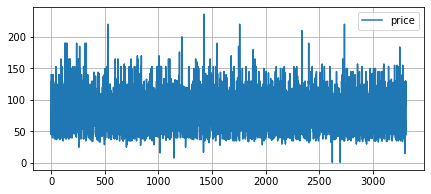

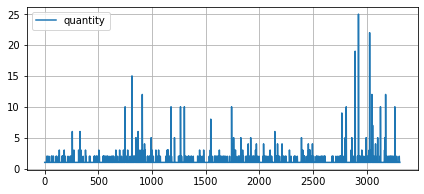

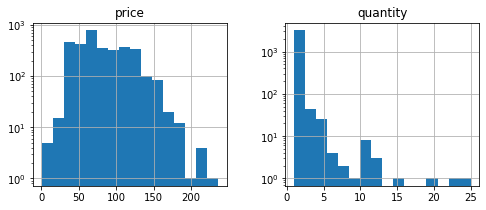

In [8]:
df.plot(y='price', kind='line', figsize=(7,3), grid=True, use_index=True)
df.plot(y='quantity', kind='line', figsize=(7,3), grid=True, use_index=True)
df.hist(column=['price', 'quantity'],bins=16, log=True, figsize=(8,3))

In [9]:
def fe(cols_gb, fe_df, matrix, feats, stats, prefix):    
    # agg features
    group = fe_df.groupby(cols_gb)[feats].agg(stats).reset_index()
    if 'local_date' in cols_gb:
        group.local_date = pd.to_datetime(group.local_date)
        matrix.local_date = pd.to_datetime(matrix.local_date)
    # merge
    matrix = matrix.merge(
        group
        , how='left'
        , on=cols_gb
    )
    matrix.fillna(0, inplace=True)    
    matrix.columns = [prefix+"_".join(col).strip() if len(col) == 2 else col for col in matrix.columns.values]    
#     print(matrix.columns.values)
    return matrix

def lag_feature(df, lags, col):
    tmp = df[['region', 'local_date',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['region', 'local_date', col+'_lag_'+str(i)]
        shifted['local_date'] += pd.Timedelta(hours=i)
        df = pd.merge(df, shifted, on=['region', 'local_date'], how='left')
    return df

In [10]:
# Creating quantity rolling mean features
def create_sales_rmean_feats(df, cols_gb, feats, windows, min_periods=2, 
                             shift=1, win_type=None):
    group = df.groupby(cols_gb)
    for w in windows:
        df['_'.join([feats, 'rmean', str(w)])] = \
            group[feats].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1, size=(len(df),))
    return df

# Creating quantity rolling median features
def create_sales_rmed_feats(df, cols_gb, feats, windows, min_periods=2, 
                            shift=1, win_type=None):
    group = df.groupby(cols_gb)
    for w in windows:
        df['_'.join([feats, 'rmed', str(w)])] = \
            group[feats].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1, size=(len(df),))
    return df

# Creating quantity exponentially weighted mean features
def create_sales_ewm_feats(df, cols_gb, feats, alpha=[0.9], shift=[1]):
    group = df.groupby(cols_gb)
    for a in alpha:
        for s in shift:
            df['_'.join([feats, 'lag', str(s), 'ewm', str(a)])] = \
                group[feats].shift(s).ewm(alpha=a).mean().values
    return df

In [11]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def mae(ytrue, ypred):
    return mean_absolute_error(ytrue, ypred)

In [12]:
def make_feature(dataset, regions, day, mode):
    
    matrix = []
    cols = ['region','local_date']
     
    dates = np.array(pd.date_range(dataset.local_date.min(), dataset.local_date.max() + pd.Timedelta(days=1), freq="1h").to_pydatetime()).astype('datetime64[ns]')
    matrix = list(product(regions, dates))    
    matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
    matrix.local_date = pd.to_datetime(matrix.local_date)
    matrix['year'] = matrix.local_date.dt.year
    matrix['month'] = matrix.local_date.dt.month
    matrix['day'] = matrix.local_date.dt.day
    matrix['hour'] = matrix.local_date.dt.hour

    cols_gb = ['region', 'local_date']
    feats = ['quantity']
    stats = ['sum']
    prefix=''
    matrix = fe(cols_gb, dataset, matrix, feats, stats, prefix)
    
#     masked_train = (matrix.day < day) 
#     masked_valid = (matrix.day == day) 
#     masked_test = (matrix.day > day)
    
    masked_train = matrix.local_date < day
    masked_valid = matrix.local_date.between(day, day+pd.Timedelta(days=1, hours=1), inclusive=True)
    masked_test = matrix.local_date > day + pd.Timedelta(days=1)
     
    matrix.loc[(masked_train), 'train_or_test'] = 'train'
    matrix.loc[(masked_valid), 'train_or_test'] = 'val'
    matrix.loc[(masked_test), 'train_or_test'] = 'test'
        
#     print('Train shape: {}'.format(matrix.loc[matrix.train_or_test=='train',:].shape))
#     print('Validation shape: {}'.format(matrix.loc[matrix.train_or_test=='val',:].shape))  
#     print('No train shape: {}'.format(matrix.loc[matrix.train_or_test=='test',:].shape))  
        
    train = matrix.loc[matrix.train_or_test.isin(['train','val']), :].copy()
    Y_train = train.loc[train.train_or_test=='train', 'quantity_sum'].reset_index(drop=True)
    Y_valid = train.loc[train.train_or_test=='val', 'quantity_sum'].reset_index(drop=True)
    train.loc[train.train_or_test=='val', ['quantity_sum']] = np.nan
    train.loc[train.train_or_test=='test', ['quantity_sum']] = np.nan
    
    lags = [24,36,48]
    train = lag_feature(train, lags, 'quantity_sum')
    cols_to_drop = []
    
    #Добавляем "скользящие" признаки
    train = create_sales_rmean_feats(train, cols_gb=['region'], 
                                 feats='quantity_sum', windows=[4,12,24], 
                                 min_periods=4, win_type='triang')

    train = create_sales_rmed_feats(train, cols_gb=['region'], 
                                feats='quantity_sum', windows=[4,12,24], 
                                min_periods=4, win_type=None)

    train = create_sales_ewm_feats(train, cols_gb=['region'], 
                               feats='quantity_sum', 
                               alpha=[0.95, 0.9, 0.85], 
                               shift=[1,4,8])
    
    cols_to_drop += ['year', 'month','train_or_test','quantity_sum']
    features = [col for col in train.columns.values if col not in cols_to_drop]

    categorical_feats = ['region',
                     'day',
                     'hour']
    for col in categorical_feats:
        train[col] = train[col].astype('category')
        
    X_train = train.loc[train.train_or_test=='train', features].reset_index(drop=True)
    X_valid = train.loc[train.train_or_test=='val', features].reset_index(drop=True)
    
    return X_train, Y_train, X_valid, Y_valid, matrix
    
    


In [13]:
mode = 'train'
valid_day = df.local_date.max()-pd.Timedelta(days=1)
regions = dataset.region.unique()

#Разбиваем на обучающую/валидационную выборки
X_train,Y_train, X_valid, Y_valid, matrix = make_feature(df, regions, valid_day, mode)
train_df = pd.concat([X_train, Y_train], axis=1)

C:\Users\bognev\anaconda3\envs\tf-gpu-clone\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\bognev\anaconda3\envs\tf-gpu-clone\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [14]:
train_df.columns.values

array(['region', 'local_date', 'day', 'hour', 'quantity_sum_lag_24',
       'quantity_sum_lag_36', 'quantity_sum_lag_48',
       'quantity_sum_rmean_4', 'quantity_sum_rmean_12',
       'quantity_sum_rmean_24', 'quantity_sum_rmed_4',
       'quantity_sum_rmed_12', 'quantity_sum_rmed_24',
       'quantity_sum_lag_1_ewm_0.95', 'quantity_sum_lag_4_ewm_0.95',
       'quantity_sum_lag_8_ewm_0.95', 'quantity_sum_lag_1_ewm_0.9',
       'quantity_sum_lag_4_ewm_0.9', 'quantity_sum_lag_8_ewm_0.9',
       'quantity_sum_lag_1_ewm_0.85', 'quantity_sum_lag_4_ewm_0.85',
       'quantity_sum_lag_8_ewm_0.85', 'quantity_sum'], dtype=object)

In [15]:
from pycaret.regression import *

all_results = []
final_model = {}

for i in tqdm([i for i in regions]):
#     print(i)
    df_subset = train_df[train_df['region'] == i]#[['local_date', 'quantity_sum', 'day', 'hour']]
    
    # initialize setup from pycaret.regression
    s = setup(df_subset, target = 'quantity_sum', train_size = 0.7,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              date_features=['local_date'],   
              numeric_features =[  'quantity_sum_lag_24',
                                   'quantity_sum_lag_36', 'quantity_sum_lag_48',
                                   'quantity_sum_rmean_4', 'quantity_sum_rmean_12',
                                   'quantity_sum_rmean_24', 'quantity_sum_rmed_4',
                                   'quantity_sum_rmed_12', 'quantity_sum_rmed_24',
                                   'quantity_sum_lag_1_ewm_0.95', 'quantity_sum_lag_4_ewm_0.95',
                                   'quantity_sum_lag_8_ewm_0.95', 'quantity_sum_lag_1_ewm_0.9',
                                   'quantity_sum_lag_4_ewm_0.9', 'quantity_sum_lag_8_ewm_0.9',
                                   'quantity_sum_lag_1_ewm_0.85', 'quantity_sum_lag_4_ewm_0.85',
                                   'quantity_sum_lag_8_ewm_0.85'],
              categorical_features = ['hour', 'day'],
              ignore_features = ['region']
              silent = True, verbose = False, session_id = 123,
              normalize = False,)
    
   
    # compare all models and select best one based on MAE
    best_model = compare_models(sort = 'R2', verbose=False, exclude = ['lightgbm'])
    
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    all_results.append(p)
    
    # finalize model i.e. fit on entire data including test set
    f = finalize_model(best_model)
    
    # attach final model to a dictionary
    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
    save_model(f, model_name='trained_models/' + str(i), verbose=True)

  1%|▌                                          | 1/80 [00:12<16:02, 12.18s/it]

Transformation Pipeline and Model Succesfully Saved


  2%|█                                          | 2/80 [00:16<10:10,  7.82s/it]

Transformation Pipeline and Model Succesfully Saved


  4%|█▌                                         | 3/80 [00:21<08:12,  6.40s/it]

Transformation Pipeline and Model Succesfully Saved


  5%|██▏                                        | 4/80 [00:26<07:21,  5.81s/it]

Transformation Pipeline and Model Succesfully Saved


  6%|██▋                                        | 5/80 [00:31<06:44,  5.39s/it]

Transformation Pipeline and Model Succesfully Saved


  8%|███▏                                       | 6/80 [00:35<06:18,  5.11s/it]

Transformation Pipeline and Model Succesfully Saved


  9%|███▊                                       | 7/80 [00:40<05:55,  4.87s/it]

Transformation Pipeline and Model Succesfully Saved


 10%|████▎                                      | 8/80 [00:54<09:16,  7.73s/it]

Transformation Pipeline and Model Succesfully Saved


 11%|████▊                                      | 9/80 [00:58<08:00,  6.77s/it]

Transformation Pipeline and Model Succesfully Saved


 12%|█████▎                                    | 10/80 [01:03<07:19,  6.27s/it]

Transformation Pipeline and Model Succesfully Saved


 14%|█████▊                                    | 11/80 [01:08<06:38,  5.77s/it]

Transformation Pipeline and Model Succesfully Saved


 15%|██████▎                                   | 12/80 [01:13<06:15,  5.52s/it]

Transformation Pipeline and Model Succesfully Saved


 16%|██████▊                                   | 13/80 [01:20<06:48,  6.09s/it]

Transformation Pipeline and Model Succesfully Saved


 18%|███████▎                                  | 14/80 [01:25<06:05,  5.54s/it]

Transformation Pipeline and Model Succesfully Saved


 19%|███████▉                                  | 15/80 [01:39<08:45,  8.09s/it]

Transformation Pipeline and Model Succesfully Saved


 20%|████████▍                                 | 16/80 [01:43<07:26,  6.97s/it]

Transformation Pipeline and Model Succesfully Saved


 21%|████████▉                                 | 17/80 [01:47<06:30,  6.21s/it]

Transformation Pipeline and Model Succesfully Saved


 22%|█████████▍                                | 18/80 [01:52<05:51,  5.67s/it]

Transformation Pipeline and Model Succesfully Saved


 24%|█████████▉                                | 19/80 [02:05<08:06,  7.98s/it]

Transformation Pipeline and Model Succesfully Saved


 25%|██████████▌                               | 20/80 [02:10<07:00,  7.00s/it]

Transformation Pipeline and Model Succesfully Saved


 26%|███████████                               | 21/80 [02:14<06:10,  6.28s/it]

Transformation Pipeline and Model Succesfully Saved


 28%|███████████▌                              | 22/80 [02:18<05:20,  5.52s/it]

Transformation Pipeline and Model Succesfully Saved


 29%|████████████                              | 23/80 [02:23<05:05,  5.36s/it]

Transformation Pipeline and Model Succesfully Saved


 30%|████████████▌                             | 24/80 [02:28<04:46,  5.11s/it]

Transformation Pipeline and Model Succesfully Saved


 31%|█████████████▏                            | 25/80 [02:43<07:30,  8.20s/it]

Transformation Pipeline and Model Succesfully Saved


 32%|█████████████▋                            | 26/80 [02:48<06:21,  7.07s/it]

Transformation Pipeline and Model Succesfully Saved


 34%|██████████████▏                           | 27/80 [02:55<06:16,  7.10s/it]

Transformation Pipeline and Model Succesfully Saved


 35%|██████████████▋                           | 28/80 [02:58<05:11,  5.99s/it]

Transformation Pipeline and Model Succesfully Saved


 36%|███████████████▏                          | 29/80 [03:02<04:37,  5.43s/it]

Transformation Pipeline and Model Succesfully Saved


 38%|███████████████▊                          | 30/80 [03:15<06:23,  7.67s/it]

Transformation Pipeline and Model Succesfully Saved


 39%|████████████████▎                         | 31/80 [03:20<05:29,  6.71s/it]

Transformation Pipeline and Model Succesfully Saved


 40%|████████████████▊                         | 32/80 [03:33<07:03,  8.82s/it]

Transformation Pipeline and Model Succesfully Saved


 41%|█████████████████▎                        | 33/80 [03:38<05:54,  7.55s/it]

Transformation Pipeline and Model Succesfully Saved


 42%|█████████████████▊                        | 34/80 [03:42<05:03,  6.60s/it]

Transformation Pipeline and Model Succesfully Saved


 44%|██████████████████▍                       | 35/80 [03:55<06:20,  8.45s/it]

Transformation Pipeline and Model Succesfully Saved


 45%|██████████████████▉                       | 36/80 [04:00<05:20,  7.29s/it]

Transformation Pipeline and Model Succesfully Saved


 46%|███████████████████▍                      | 37/80 [04:13<06:28,  9.04s/it]

Transformation Pipeline and Model Succesfully Saved


 48%|███████████████████▉                      | 38/80 [04:17<05:23,  7.70s/it]

Transformation Pipeline and Model Succesfully Saved


 49%|████████████████████▍                     | 39/80 [04:22<04:35,  6.72s/it]

Transformation Pipeline and Model Succesfully Saved


 50%|█████████████████████                     | 40/80 [04:26<03:52,  5.81s/it]

Transformation Pipeline and Model Succesfully Saved


 51%|█████████████████████▌                    | 41/80 [04:30<03:27,  5.32s/it]

Transformation Pipeline and Model Succesfully Saved


 52%|██████████████████████                    | 42/80 [04:43<04:57,  7.84s/it]

Transformation Pipeline and Model Succesfully Saved


 54%|██████████████████████▌                   | 43/80 [04:48<04:13,  6.84s/it]

Transformation Pipeline and Model Succesfully Saved


 55%|███████████████████████                   | 44/80 [05:01<05:18,  8.84s/it]

Transformation Pipeline and Model Succesfully Saved


 56%|███████████████████████▋                  | 45/80 [05:06<04:26,  7.61s/it]

Transformation Pipeline and Model Succesfully Saved


 57%|████████████████████████▏                 | 46/80 [05:11<03:47,  6.70s/it]

Transformation Pipeline and Model Succesfully Saved


 59%|████████████████████████▋                 | 47/80 [05:15<03:11,  5.81s/it]

Transformation Pipeline and Model Succesfully Saved


 60%|█████████████████████████▏                | 48/80 [05:19<02:56,  5.52s/it]

Transformation Pipeline and Model Succesfully Saved


 61%|█████████████████████████▋                | 49/80 [05:24<02:41,  5.21s/it]

Transformation Pipeline and Model Succesfully Saved


 62%|██████████████████████████▎               | 50/80 [05:29<02:32,  5.09s/it]

Transformation Pipeline and Model Succesfully Saved


 64%|██████████████████████████▊               | 51/80 [05:43<03:46,  7.82s/it]

Transformation Pipeline and Model Succesfully Saved


 65%|███████████████████████████▎              | 52/80 [05:57<04:30,  9.66s/it]

Transformation Pipeline and Model Succesfully Saved


 66%|███████████████████████████▊              | 53/80 [06:01<03:40,  8.15s/it]

Transformation Pipeline and Model Succesfully Saved


 68%|████████████████████████████▎             | 54/80 [06:16<04:21, 10.04s/it]

Transformation Pipeline and Model Succesfully Saved


 69%|████████████████████████████▉             | 55/80 [06:20<03:28,  8.35s/it]

Transformation Pipeline and Model Succesfully Saved


 70%|█████████████████████████████▍            | 56/80 [06:27<03:11,  7.98s/it]

Transformation Pipeline and Model Succesfully Saved


 71%|█████████████████████████████▉            | 57/80 [06:40<03:38,  9.51s/it]

Transformation Pipeline and Model Succesfully Saved


 72%|██████████████████████████████▍           | 58/80 [06:54<03:57, 10.77s/it]

Transformation Pipeline and Model Succesfully Saved


 74%|██████████████████████████████▉           | 59/80 [07:00<03:12,  9.17s/it]

Transformation Pipeline and Model Succesfully Saved


 75%|███████████████████████████████▌          | 60/80 [07:03<02:28,  7.44s/it]

Transformation Pipeline and Model Succesfully Saved


 76%|████████████████████████████████          | 61/80 [07:06<01:57,  6.18s/it]

Transformation Pipeline and Model Succesfully Saved


 78%|████████████████████████████████▌         | 62/80 [07:10<01:40,  5.59s/it]

Transformation Pipeline and Model Succesfully Saved


 79%|█████████████████████████████████         | 63/80 [07:17<01:40,  5.89s/it]

Transformation Pipeline and Model Succesfully Saved


 80%|█████████████████████████████████▌        | 64/80 [07:21<01:26,  5.38s/it]

Transformation Pipeline and Model Succesfully Saved


 81%|██████████████████████████████████▏       | 65/80 [07:25<01:11,  4.78s/it]

Transformation Pipeline and Model Succesfully Saved


 82%|██████████████████████████████████▋       | 66/80 [07:29<01:04,  4.61s/it]

Transformation Pipeline and Model Succesfully Saved


 84%|███████████████████████████████████▏      | 67/80 [07:42<01:32,  7.14s/it]

Transformation Pipeline and Model Succesfully Saved


 85%|███████████████████████████████████▋      | 68/80 [07:46<01:13,  6.08s/it]

Transformation Pipeline and Model Succesfully Saved


 86%|████████████████████████████████████▏     | 69/80 [07:58<01:29,  8.14s/it]

Transformation Pipeline and Model Succesfully Saved


 88%|████████████████████████████████████▊     | 70/80 [08:11<01:36,  9.60s/it]

Transformation Pipeline and Model Succesfully Saved


 89%|█████████████████████████████████████▎    | 71/80 [08:27<01:42, 11.35s/it]

Transformation Pipeline and Model Succesfully Saved


 90%|█████████████████████████████████████▊    | 72/80 [08:39<01:33, 11.64s/it]

Transformation Pipeline and Model Succesfully Saved


 91%|██████████████████████████████████████▎   | 73/80 [08:43<01:04,  9.19s/it]

Transformation Pipeline and Model Succesfully Saved


 92%|██████████████████████████████████████▊   | 74/80 [08:47<00:46,  7.75s/it]

Transformation Pipeline and Model Succesfully Saved


 94%|███████████████████████████████████████▍  | 75/80 [08:51<00:32,  6.48s/it]

Transformation Pipeline and Model Succesfully Saved


 95%|███████████████████████████████████████▉  | 76/80 [08:58<00:26,  6.73s/it]

Transformation Pipeline and Model Succesfully Saved


 96%|████████████████████████████████████████▍ | 77/80 [09:01<00:17,  5.71s/it]

Transformation Pipeline and Model Succesfully Saved


 98%|████████████████████████████████████████▉ | 78/80 [09:05<00:10,  5.02s/it]

Transformation Pipeline and Model Succesfully Saved


 99%|█████████████████████████████████████████▍| 79/80 [09:08<00:04,  4.52s/it]

Transformation Pipeline and Model Succesfully Saved


100%|██████████████████████████████████████████| 80/80 [09:11<00:00,  6.90s/it]

Transformation Pipeline and Model Succesfully Saved


In [ ]:
for result in all_results:
    print(result)

100%|██████████████████████████████████████████| 80/80 [00:21<00:00,  3.72it/s]


1.5346862954302565 0.12315226748049417


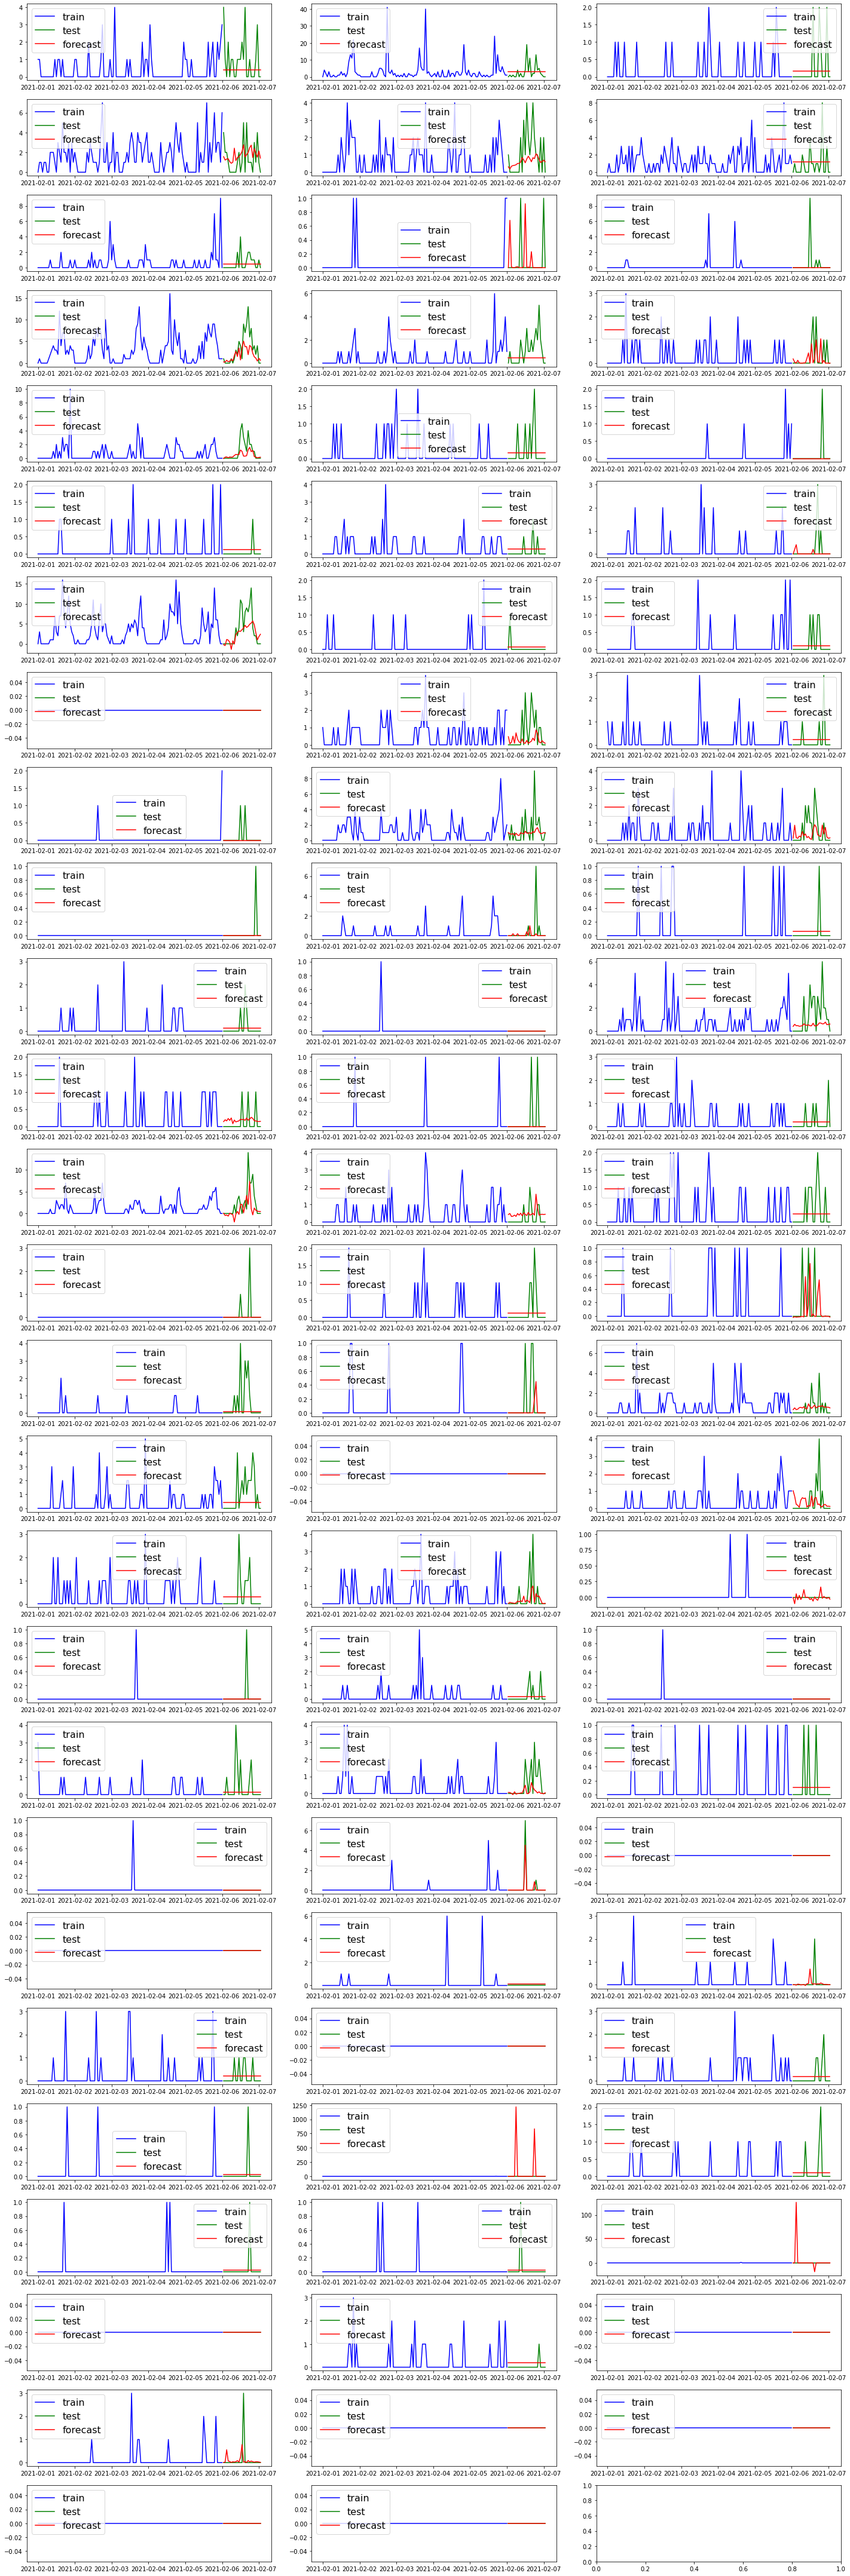

In [53]:
mode = 'train'
valid_day = df.local_date.max()-pd.Timedelta(days=1)
regions = dataset.region.unique()

from pycaret.regression import load_model, predict_model
all_score_df = []
for i in tqdm(regions):
    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=X_valid[X_valid.region==i])
    p['region'] = i
    all_score_df.append(p)
    concat_df = pd.concat(all_score_df, axis=0)

PLT = True
if PLT:
    fig, ax = plt.subplots(ceil(len(regions)/3), 3, figsize=(20, 60))
    ax = ax.flatten()

train_df = pd.concat([X_train, Y_train], axis=1)
valid_df = pd.concat([X_valid, Y_valid], axis=1)
mae, r2 = [], []
for i, reg in enumerate(regions):
        
    subset = concat_df[concat_df['region'] == reg]
    train = train_df[train_df['region'] == reg][['local_date', 'quantity_sum']]   
    valid = valid_df[valid_df['region'] == reg][['local_date', 'quantity_sum']]   
    mae.append(mean_absolute_error(valid.quantity_sum, subset.Label))
    r2.append(r2_score(valid.quantity_sum,subset.Label))
    plot_grid_forecast(i, ax, train, valid, subset.Label)  

mae, r2 = np.array(mae), np.array(r2)

print(mae.mean(), r2.mean())

if PLT:
    plt.tight_layout()

In [26]:
# create a date range from 2013 to 2019
test_day = matrix.local_date.max()-pd.Timedelta(days=1)
all_dates = np.array(pd.date_range(test_day, matrix.local_date.max(), freq="1h").to_pydatetime()).astype('datetime64[ns]')
score_df = pd.DataFrame()# add columns to dataset
score_df['local_date'] = all_dates
score_df['month'] = [i.month for i in score_df['local_date']]
score_df['year'] = [i.year for i in score_df['local_date']]
score_df['day'] = [i.day for i in score_df['local_date']]
score_df['hour'] = [i.hour for i in score_df['local_date']]


,region,local_date,day,hour,quantity_sum_lag_24,quantity_sum_lag_36,quantity_sum_lag_48,quantity_sum_rmean_4,quantity_sum_rmean_12,quantity_sum_rmean_24,...,quantity_sum_rmed_24,quantity_sum_lag_1_ewm_0.95,quantity_sum_lag_4_ewm_0.95,quantity_sum_lag_8_ewm_0.95,quantity_sum_lag_1_ewm_0.9,quantity_sum_lag_4_ewm_0.9,quantity_sum_lag_8_ewm_0.9,quantity_sum_lag_1_ewm_0.85,quantity_sum_lag_4_ewm_0.85,quantity_sum_lag_8_ewm_0.85
0,33,2021-02-07 02:00:00,7,2,1.0,0.0,0.0,1.82696,-0.534981,0.169542,...,-0.884905,0.007244,0.950006,0.950482,0.0279,0.900090,0.903709,0.060245,0.850436,0.862046
1,33,2021-02-07 03:00:00,7,3,0.0,2.0,0.0,NaN,0.814411,1.810401,...,2.052038,0.007244,2.897500,0.047524,0.0279,2.790009,0.090371,0.060245,2.677565,0.129307
2,33,2021-02-07 04:00:00,7,4,2.0,0.0,1.0,NaN,1.061830,1.515970,...,0.786321,0.007244,0.144875,0.002376,0.0279,0.279001,0.009037,0.060245,0.401635,0.019396
3,33,2021-02-07 05:00:00,7,5,0.0,1.0,0.0,NaN,-0.572038,0.418583,...,2.190842,0.007244,0.007244,0.000119,0.0279,0.027900,0.000904,0.060245,0.060245,0.002909
4,33,2021-02-07 06:00:00,7,6,1.0,2.0,0.0,NaN,1.543803,1.153995,...,3.136521,0.007244,0.007244,0.950006,0.0279,0.027900,0.900090,0.060245,0.060245,0.850436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,82,2021-02-07 21:00:00,7,21,0.0,0.0,0.0,NaN,NaN,-0.361193,...,-0.408662,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1916,82,2021-02-07 22:00:00,7,22,0.0,0.0,0.0,NaN,NaN,0.380456,...,-0.321512,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1917,82,2021-02-07 23:00:00,7,23,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1918,82,2021-02-08 00:00:00,8,0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000


In [42]:
mode = 'test'
test_day = df.local_date.max() + pd.Timedelta(hours=1)
X_train,Y_train, X_test, Y_test, matrix = make_feature(df, regions, test_day, mode)

# Final train and val datasets
print('X Train shape:{}, X test shape:{}'.format(X_train.shape, X_test.shape))
print('Y Train shape:{}, Y test shape:{}'.format(Y_train.shape, Y_test.shape))



X Train shape:(11680, 22), X test shape:(1920, 22)
Y Train shape:(11680,), Y test shape:(1920,)


In [27]:
from pycaret.regression import load_model, predict_model
all_score_df = []
for i in tqdm(regions):
    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=X_test[X_test.region==i])
    p['region'] = i
    all_score_df.append(p)
    concat_df = pd.concat(all_score_df, axis=0)
concat_df.sample(10)

100%|██████████████████████████████████████████| 80/80 [00:17<00:00,  4.51it/s]


,region,local_date,day,hour,quantity_sum_lag_24,quantity_sum_lag_36,quantity_sum_lag_48,quantity_sum_rmean_4,quantity_sum_rmean_12,quantity_sum_rmean_24,...,quantity_sum_lag_1_ewm_0.95,quantity_sum_lag_4_ewm_0.95,quantity_sum_lag_8_ewm_0.95,quantity_sum_lag_1_ewm_0.9,quantity_sum_lag_4_ewm_0.9,quantity_sum_lag_8_ewm_0.9,quantity_sum_lag_1_ewm_0.85,quantity_sum_lag_4_ewm_0.85,quantity_sum_lag_8_ewm_0.85,Label
1216,42,2021-02-07 18:00:00,7,18,0.0,0.0,0.0,NaN,NaN,-0.855013,...,5.273559e-71,5.273559e-71,5.273559e-71,9.000000e-55,9.000000e-55,9.000000e-55,2.743765e-45,2.743765e-45,2.743765e-45,0.009137
1718,39,2021-02-07 16:00:00,7,16,0.0,0.0,0.0,NaN,NaN,0.789319,...,3.295975e-76,3.295975e-76,3.295975e-76,9.000000e-59,9.000000e-59,9.000000e-59,1.389031e-48,1.389031e-48,1.389031e-48,0.009689
533,26,2021-02-07 07:00:00,7,7,0.0,2.0,1.0,NaN,0.468388,2.440266,...,1.247180e-04,1.247180e-04,4.988720e-02,9.919108e-04,9.919108e-04,9.919108e-02,3.320418e-03,3.320418e-03,1.475741e-01,0.230000
110,78,2021-02-07 16:00:00,7,16,2.0,0.0,0.0,NaN,NaN,0.829369,...,9.523781e-02,9.523781e-02,9.523781e-02,1.818101e-01,1.818101e-01,1.818101e-01,2.608156e-01,2.608156e-01,2.608156e-01,0.779513
1784,1,2021-02-07 10:00:00,7,10,0.0,0.0,0.0,NaN,-0.479043,0.154339,...,3.967385e-227,3.967385e-227,3.967385e-227,9.000000e-175,9.000000e-175,9.000000e-175,3.709352e-144,3.709352e-144,3.709352e-144,0.000000
1854,32,2021-02-07 08:00:00,7,8,0.0,0.0,0.0,NaN,0.288853,1.097037,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.638974e-289,1.638974e-289,1.092649e-288,0.000000
1217,42,2021-02-07 19:00:00,7,19,0.0,0.0,0.0,NaN,NaN,1.267048,...,5.273559e-71,5.273559e-71,5.273559e-71,9.000000e-55,9.000000e-55,9.000000e-55,2.743765e-45,2.743765e-45,2.743765e-45,0.183364
680,41,2021-02-07 10:00:00,7,10,0.0,0.0,0.0,NaN,-0.604564,-0.518594,...,6.041406e-06,6.041406e-06,6.041406e-06,9.630001e-05,9.630001e-05,9.630001e-05,4.980875e-04,4.980875e-04,4.980875e-04,0.400000
1719,39,2021-02-07 17:00:00,7,17,0.0,0.0,0.0,NaN,NaN,0.021977,...,3.295975e-76,3.295975e-76,3.295975e-76,9.000000e-59,9.000000e-59,9.000000e-59,1.389031e-48,1.389031e-48,1.389031e-48,0.003380
554,5,2021-02-07 04:00:00,7,4,0.0,0.0,0.0,NaN,2.260292,0.386397,...,1.781324e-05,3.562648e-04,2.375000e-03,2.700900e-04,2.700900e-03,9.000000e-03,1.292390e-03,8.615932e-03,1.912500e-02,0.214876


In [51]:
def plot_grid_forecast(i, ax, series_train, series_test, forecast):  
    ax[i].plot(series_train.local_date, series_train.quantity_sum, label="train", color="b")
    ax[i].plot(series_test.local_date, series_test.quantity_sum, label="test", color="g")
#     forecast.index = series_test.index
    ax[i].plot(series_test.local_date, forecast, label="forecast", color="r")
    ax[i].legend(prop={"size": 16})

2.426125903149422 0.25


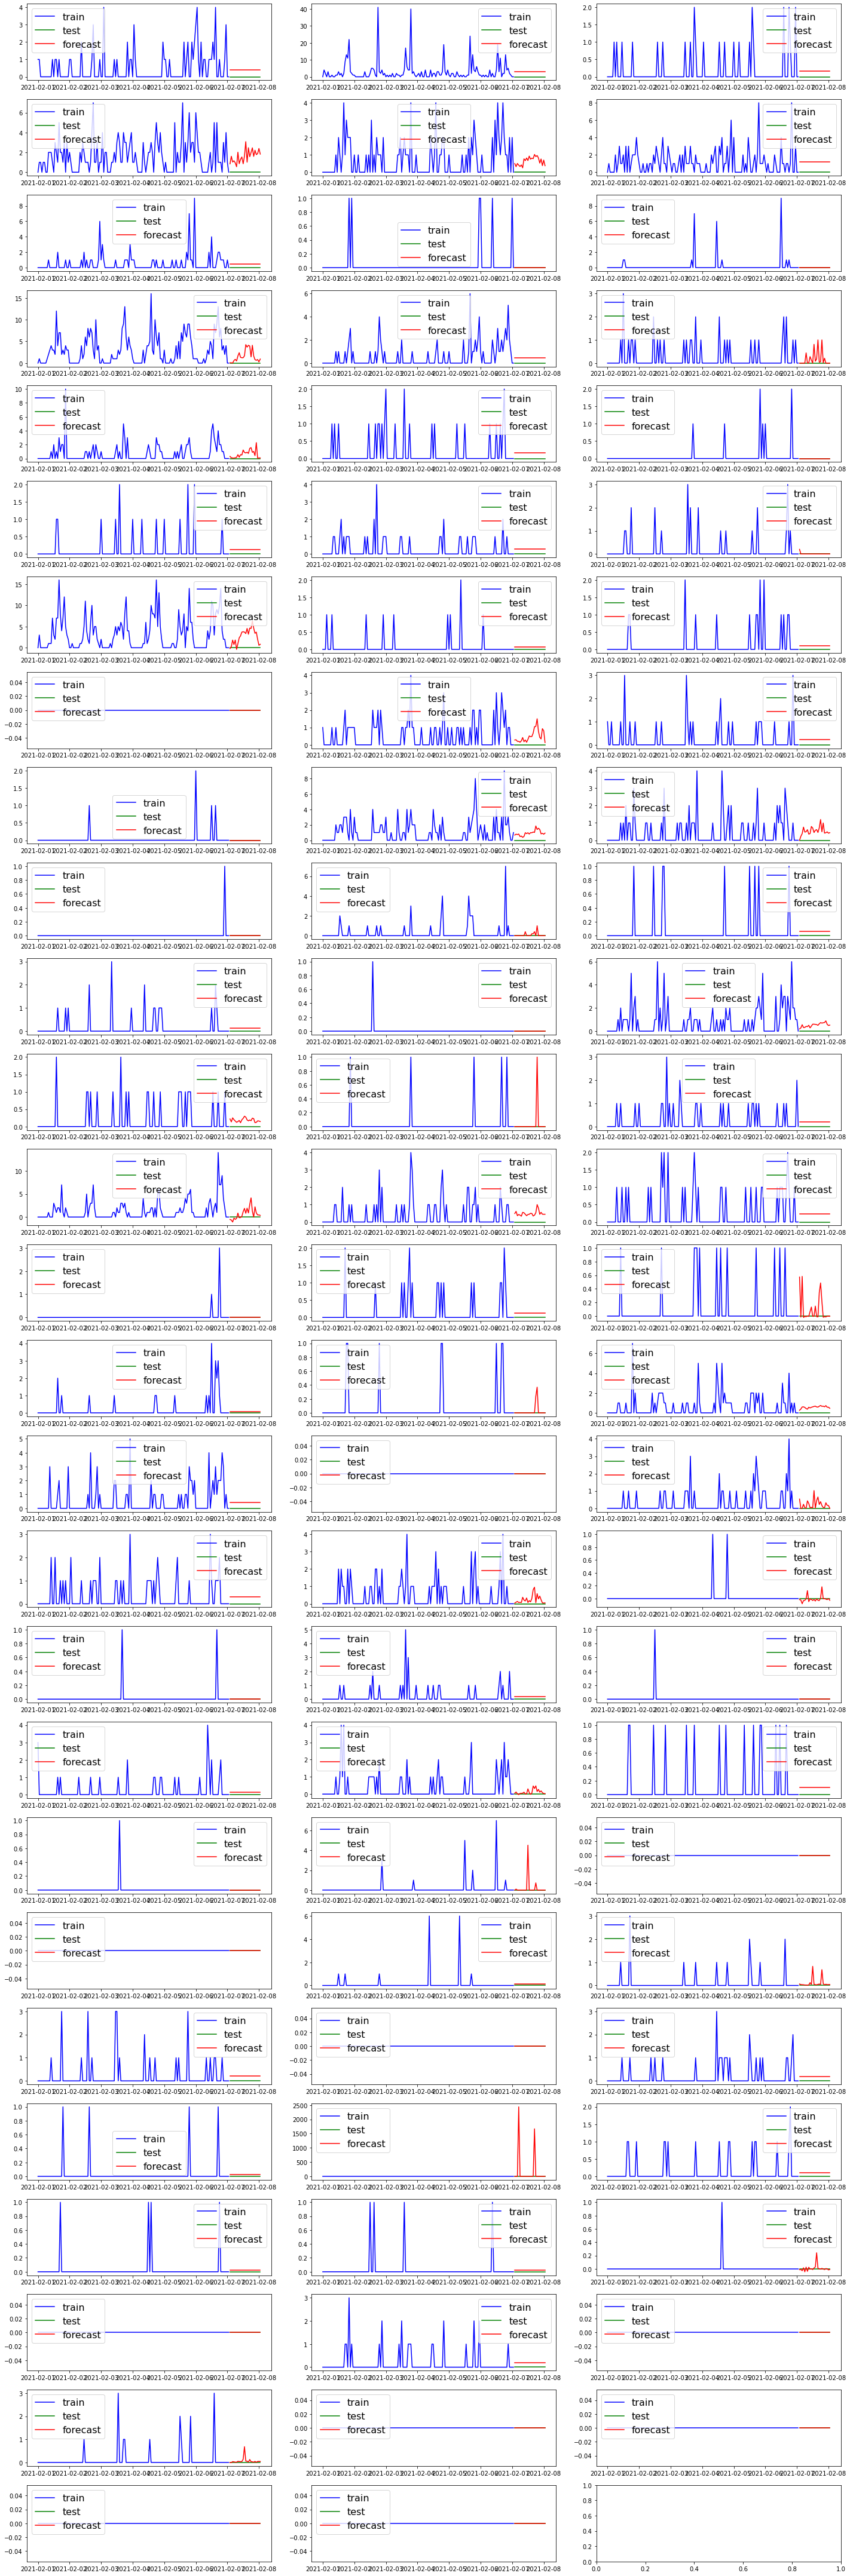

In [52]:
PLT = True
if PLT:
    fig, ax = plt.subplots(ceil(len(regions)/3), 3, figsize=(20, 60))
    ax = ax.flatten()

train_df = pd.concat([X_train, Y_train], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)
mae, r2 = [], []
for i, reg in enumerate(regions):
        
    subset = concat_df[concat_df['region'] == reg]
    train = train_df[train_df['region'] == reg][['local_date', 'quantity_sum']]   
    test = test_df[test_df['region'] == reg][['local_date', 'quantity_sum']]   
    mae.append(mean_absolute_error(test.quantity_sum, subset.Label))
    r2.append(r2_score(test.quantity_sum,subset.Label))
    plot_grid_forecast(i, ax, train, test, subset.Label)  

mae, r2 = np.array(mae), np.array(r2)

print(mae.mean(), r2.mean())

if PLT:
    plt.tight_layout()